In [1]:
# import sys
# sys.path.append('/Users/hamzacostelle/opt/anaconda3/envs/project-env/lib/python3.7/site-packages')

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
%matplotlib inline
import seaborn as sns
sns.set()
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
!curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 1963k  100 1963k    0     0  1006k      0  0:00:01  0:00:01 --:--:-- 1006k


# Time-Series Forecasting with Beijing PM2.5 Dataset
**Duration**: Year 2010 to 2014

## Attribute Information:

- No: row number
- year: year of data in this row
- month: month of data in this row
- day: day of data in this row
- hour: hour of data in this row
- pm2.5: PM2.5 concentration (ug/m^3), Particle Matter 2.5 denotes pollution in air.
- DEWP: Dew Point (â„ƒ)
- TEMP: Temperature (â„ƒ)
- PRES: Pressure (hPa)
- cbwd: Combined wind direction
- Iws: Cumulated wind speed (m/s)
- Is: Cumulated hours of snow
- Ir: Cumulated hours of rain

- The concentration of an air pollutant (eg. ozone) is given in micrograms (one-millionth of a gram) per cubic meter air or µg/m3.


- 5 is considered safe by the US Environmental Protection Agency's national ambient air quality standards so long as a person breathes in an average of 12 micrograms per cubic meter of air (μg/m3) or less per day over the duration of a year.

Response Variable: pm2.5<br>
Explanatory Variables: All other attributes

## Basic Exploration and Feature Engineering 

We will take a high-level overview of the dataset and look at the attributes.Cleaning and pre-processing data will take care of issues like 
- Setting up data as Time-series data using datetime parser, creating index as time
- Renaming columns to remove ambiguity
- Addressing null values, incorrect data-types
- Getting data information for attribute columns 
- Getting Statistical information on distribution of data, understand central tendencies, outliers if any

In [103]:
# Look at our dataset first
df = pd.read_csv('PRSA_data_2010.1.1-2014.12.31.csv', index_col=0)
df.sample(10)

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
No,,,,,,,,,,,,
12011,2011,5,16,10,71.0,4,21.0,1015.0,SE,1.79,0,0
38025,2014,5,4,8,51.0,-9,13.0,1017.0,NW,183.73,0,0
20575,2012,5,7,6,76.0,8,16.0,1005.0,cv,0.89,0,0
28250,2013,3,23,1,50.0,-3,0.0,1017.0,SE,71.96,0,0
36712,2014,3,10,15,111.0,-9,9.0,1021.0,cv,3.58,0,0
11203,2011,4,12,18,88.0,-4,23.0,1009.0,SE,33.97,0,0
42480,2014,11,5,23,6.0,-7,7.0,1024.0,NE,1.79,0,0
10106,2011,2,26,1,42.0,-11,0.0,1031.0,SE,44.26,0,0
20301,2012,4,25,20,6.0,-7,13.0,1008.0,NW,198.01,0,0


Before further analysis we will convert our data into a time series dataframe

In [104]:
# parse the datetime columns into a single column
from datetime import datetime

def parse_date(x):
    return datetime.strptime(x,'%Y %m %d %H')

df1 = pd.read_csv('PRSA_data_2010.1.1-2014.12.31.csv', index_col=0,date_parser=parse_date,parse_dates=[['year','month','day','hour']]) 
df1.drop(columns='No', axis=1, inplace=True)
# set date as index
df1.index.name = 'time'
df1.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
time,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0


Next we will change the column names to remove ambiguity, so we don't have to refer again from the above attribute details.

In [105]:
# Change column names
df2 = df1.copy()
df2.columns = ['pm2.5','dew_pt','temp','pressure', 'wind_dir','wind_spd','cum_snow','cum_rain']
df2.head(30)
# df2.sample(30)

,pm2.5,dew_pt,temp,pressure,wind_dir,wind_spd,cum_snow,cum_rain
time,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0
2010-01-01 05:00:00,NaN,-19,-10.0,1017.0,NW,16.10,0,0
2010-01-01 06:00:00,NaN,-19,-9.0,1017.0,NW,19.23,0,0
2010-01-01 07:00:00,NaN,-19,-9.0,1017.0,NW,21.02,0,0
2010-01-01 08:00:00,NaN,-19,-9.0,1017.0,NW,24.15,0,0


In [106]:
#  check data for nulls
df2.isnull().sum()

pm2.5       2067
dew_pt         0
temp           0
pressure       0
wind_dir       0
wind_spd       0
cum_snow       0
cum_rain       0
dtype: int64

Looking at the dataset, we can see that our 'pollution' column has about 2067 NaN values and we don't have data for day 1 on Jan, 2010.<br>
We can't drop all the null records based on pollution column.Hence we will first remove the rows of records from day 1 from the data 
set and then use forward fill to remove null data completely from that column.

In [107]:
# Fix nulls in 'pm2.5, the pollution column
df2 = df2[24:].fillna(method='ffill')
df2.sample(15)

,pm2.5,dew_pt,temp,pressure,wind_dir,wind_spd,cum_snow,cum_rain
time,,,,,,,,
2012-06-20 10:00:00,82.0,18,27.0,1003.0,cv,3.13,0,0
2011-06-25 03:00:00,31.0,17,19.0,1012.0,NW,11.63,0,0
2014-02-26 17:00:00,446.0,0,9.0,1021.0,NW,4.92,0,1
2014-03-04 18:00:00,11.0,-29,7.0,1026.0,NW,78.23,0,0
2014-11-20 16:00:00,315.0,0,8.0,1016.0,SE,8.94,0,0
2011-11-07 08:00:00,34.0,2,7.0,1029.0,NW,21.91,0,0
2010-04-20 11:00:00,69.0,7,16.0,1020.0,cv,2.68,0,0
2011-09-04 01:00:00,191.0,19,19.0,1014.0,NE,0.89,0,0
2012-11-04 11:00:00,22.0,3,4.0,1011.0,NW,150.21,0,26


Our dataset now looks good. We have taken a sample instead of head to randomly check our data. Let's look at the data information. 
We can get the null data details and data types.

In [108]:
df2.info()
df2.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43800 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pm2.5     43800 non-null  float64
 1   dew_pt    43800 non-null  int64  
 2   temp      43800 non-null  float64
 3   pressure  43800 non-null  float64
 4   wind_dir  43800 non-null  object 
 5   wind_spd  43800 non-null  float64
 6   cum_snow  43800 non-null  int64  
 7   cum_rain  43800 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB


(43800, 8)

The above info shows that we have no null data in our columns. The data types of most of our numerical columns are integers or float.The categorical column 'win_dir' is of type object so we are good.<br>
The shape tells us that we have 43800 records and 8 attribute columns

## Exploratory Data Analysis and Visualization of data

We will begin our EDA with simple distribution statistics that include mean, standard deviation, quartiles etc.

In [84]:
df2.describe()

,pm2.5,dew_pt,temp,pressure,wind_spd,cum_snow,cum_rain
count,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


**Observation**:
- Looking at the max values for columns pm2.5, wind_spd, cum_snow and cum_rain are quite far from the 75% quartile indicating outliers.
- We have some negative values for dew_pt and temp

### Visualization of data distribution

Let's plot the categorical column and numerical columns to understand the distribution of data.<br>
**Boxplots** are very useful in visualizing the outliers. We will use a box plot to plot our categorical column wind_dir

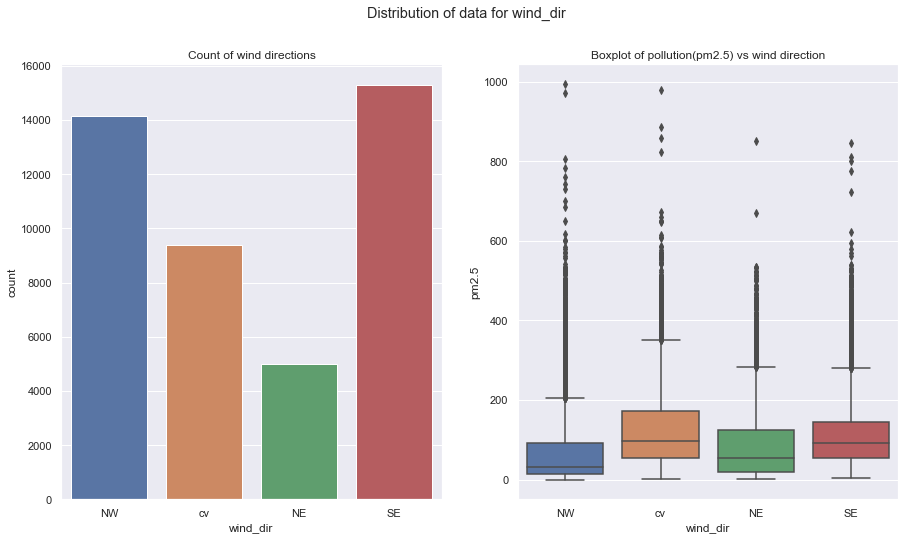

In [85]:
# Create a seaborn count plot  for the categorical column wind_dir

fig, ax = plt.subplots(1,2, figsize=(15,8));
fig.suptitle('Distribution of data for wind_dir');
sns.countplot(data=df2, x='wind_dir', ax=ax[0]);
ax[0].set_title('Count of wind directions');
sns.boxplot(data=df2,x='wind_dir', y='pm2.5', ax=ax[1]);
ax[1].set_title('Boxplot of pollution(pm2.5) vs wind direction');

**Observation**: Categorical column

- The count plot of wind direction shows the highest count for SE direction followed by NW direction
- The box plot shows overlapping boxes, so the groups are not very different
- However the median lines of both NW and NE lie out side of boxes for both SE and CV indicating a difference.
- All the groups have outliers on the max side.
- As a result data for all the wind directions groups are skewed to right.

Next we have created a numeric dataframe, df2_numeric out of the df2, to analyse the data distribution in numeric column

In [109]:
# Created numeric dataframe
df2_numeric = df2.drop(['wind_dir'], axis=1)
df2_numeric.sample(15)

,pm2.5,dew_pt,temp,pressure,wind_spd,cum_snow,cum_rain
time,,,,,,,
2012-02-17 07:00:00,10.0,-23,-8.0,1033.0,178.82,0,0
2014-04-12 20:00:00,119.0,-2,17.0,1015.0,6.26,0,0
2014-10-15 10:00:00,23.0,-2,21.0,1014.0,9.83,0,0
2013-07-17 22:00:00,49.0,20,27.0,1005.0,36.65,0,0
2010-11-10 23:00:00,227.0,-1,3.0,1013.0,4.92,0,0
2013-07-24 23:00:00,48.0,18,26.0,1000.0,0.89,0,0
2014-06-16 21:00:00,111.0,20,26.0,1001.0,1.78,0,0
2014-04-29 06:00:00,83.0,7,11.0,1016.0,0.89,0,0
2013-11-12 12:00:00,18.0,-10,15.0,1025.0,1.79,0,0


In [87]:
df2_numeric.columns

Index(['pm2.5', 'dew_pt', 'temp', 'pressure', 'wind_spd', 'cum_snow',
       'cum_rain'],
      dtype='object')

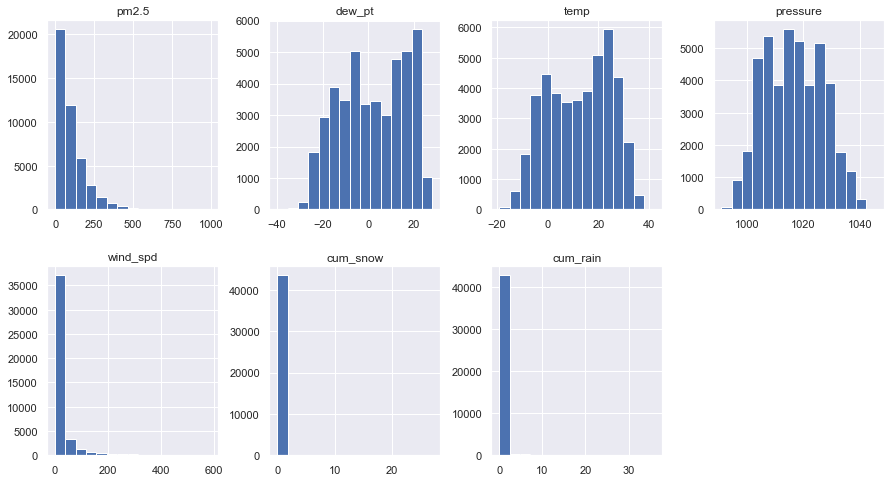

In [110]:
df2_numeric.hist(bins=15,figsize=(15,8),layout=(2,4));

**Observation**: Numeric Columns

- The pm2.5 and wind_spd data is skewed to right.
- Both columns dew_pt and temp are bimodal and have negative numbers.
- The data for pressure is multimodal.
- For cum_snow and cum_rain except for few outlier values, most of the data has 0 values

Our next plot provides us with a better insight of the data distribution over a period of five year from 2010 to 2014 for the response variable pm2.5 and the explanatory variables .

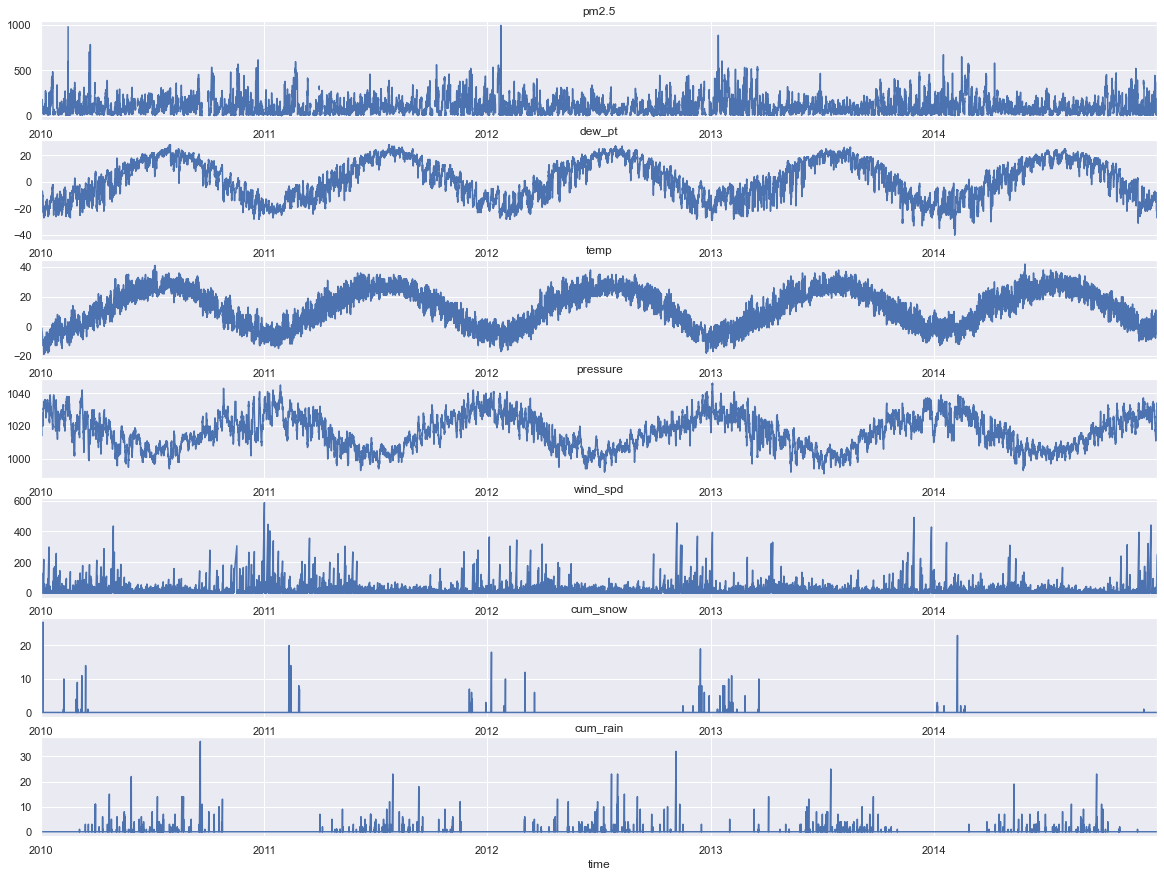

In [89]:
# Data for numeric columns
fig, ax = plt.subplots(7, 1, figsize=(20,15))
for i,col in enumerate(df2_numeric.columns):
    df2[col].plot(ax=ax[i])
    ax[i].set_title(col)

**Observation**: 
1. In these 5 years of data for pm2.5 column, we can observe less pollutiuon in 2011 and 2012 and increase in pollution over year 2013 and 2014.

2. The explanatory variables dew_pt is positively correlated to temperature and both are inversely correlated to pm2.5 which is our<br>
pollution column. At low dew point and low atmospheric temperature, we can see increase in particle matter 2.5. Dew is more effective <br>
in removing airborne particles in normal weather than in haze, foggy or colder temperature since warmer temperature moves pollutants from ground to higher altitude.

3. Rain and snow has relatively low impact on air pollution unless there is really heavy rain or snow.

4. Some of the outliers in the pm2.5 column per year relate to higher wind speed. Higher wind speed can spread more dust and disperse air contaminants.

### Resampling
*Resampling* generates a unique sampling distribution on the basis of the actual data. We can apply various frequency to resample our time series data.
<br> We will resample the pm2.5 column (response variable) based on months and plot the data for visualization

In [111]:
# Resampling the time series data based on months 'M'
# Find mean of particle matter 2.5 of each month for 
# a duration of 12 months for years 2010 to 
ts_mean_month = df2['pm2.5'].resample('M').mean()
ts_mean_month.head(15)

time
2010-01-31     84.073611
2010-02-28     98.547619
2010-03-31     99.971774
2010-04-30     79.865278
2010-05-31     86.892473
2010-06-30    110.325000
2010-07-31    123.647849
2010-08-31    101.842742
2010-09-30     85.969444
2010-10-31    118.727151
2010-11-30    130.580556
2010-12-31     97.333333
2011-01-31     42.353495
2011-02-28    150.321429
2011-03-31     67.802419
Freq: M, Name: pm2.5, dtype: float64

**Observation**:
Resampling and getting the monthly means do not address the outliers in the pm2.5 column.


In [112]:
#Creating dummy variables for the wind_dir: Combined wind direction
df2 = df2.join(pd.get_dummies(df2['wind_dir'])) # one-hot encoding
del df2['wind_dir']
df2.head()

,pm2.5,dew_pt,temp,pressure,wind_spd,cum_snow,cum_rain,NE,NW,SE,cv
time,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0


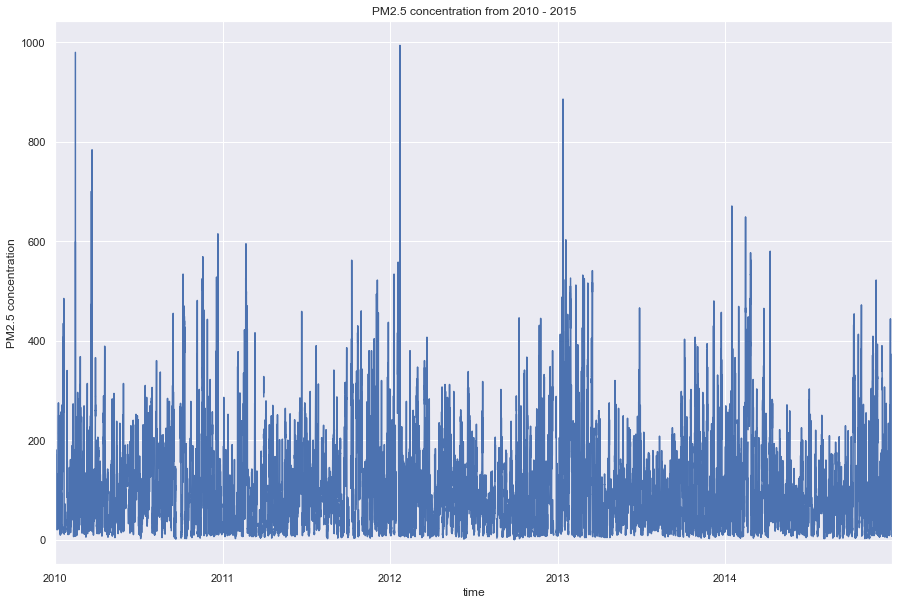

In [92]:
# Distribution of pollution data over 5 years(2010 - 2014)
plt.subplots(figsize=(15,10))
plt.xlabel('Time')
plt.ylabel('PM2.5 concentration')
plt.title('PM2.5 concentration from 2010 - 2015')
df2['pm2.5'].plot()
plt.show()

**Observation**:
Plotting only the pm2.5 data over five years do not give us much information. <br>
Except for some outliers in year 2010 (represented by 0 - 2011), 2012 and 2014, over all pollution <br>
has been high from 2010 to 2012 and higher after that.

In [113]:
scatter_y = df2['pm2.5'].resample('D').mean()
scatter_x = df2['pm2.5'].resample('D').mean().index

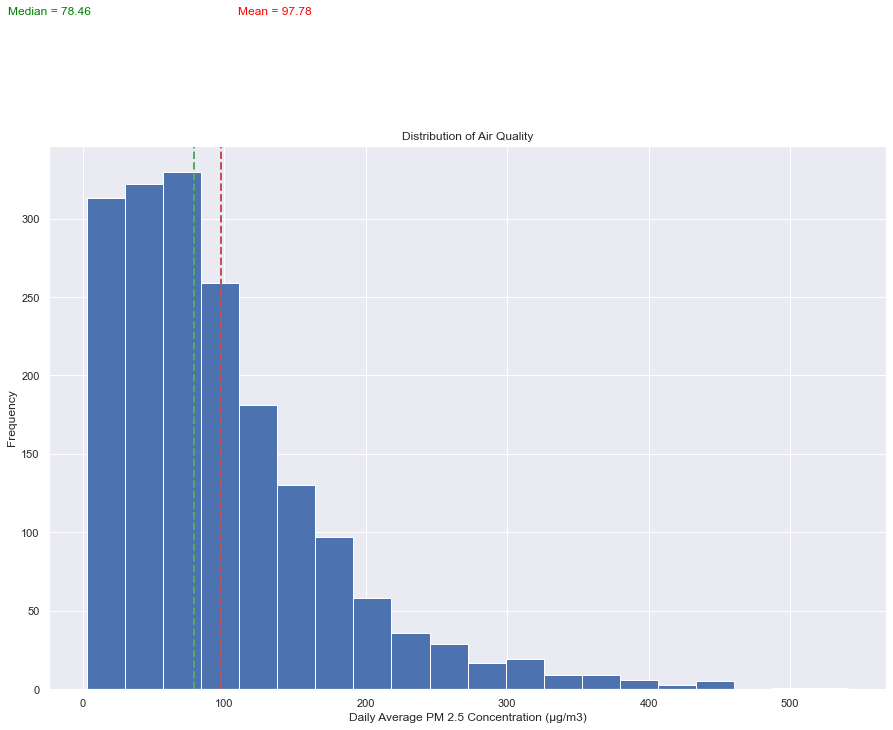

In [114]:
# Daily distribution of air quality - getting mean and median
plt.figure(figsize=(15,10))
plt.hist(scatter_y.dropna(), bins = 20, edgecolor='w', lw=1)
plt.xlabel('Daily Average PM 2.5 Concentration (μg/m3)')
plt.ylabel('Frequency')
plt.title('Distribution of Air Quality')
plt.text(110, 430, 'Mean = ' + str(round(scatter_y.dropna().mean(),2)), color = 'red')
plt.text(-53, 430, 'Median = ' + str(round(scatter_y.dropna().median(),2)), color = 'green')
plt.axvline(scatter_y.dropna().mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(scatter_y.dropna().median(), color='g', linestyle='dashed', linewidth=2)
plt.show()

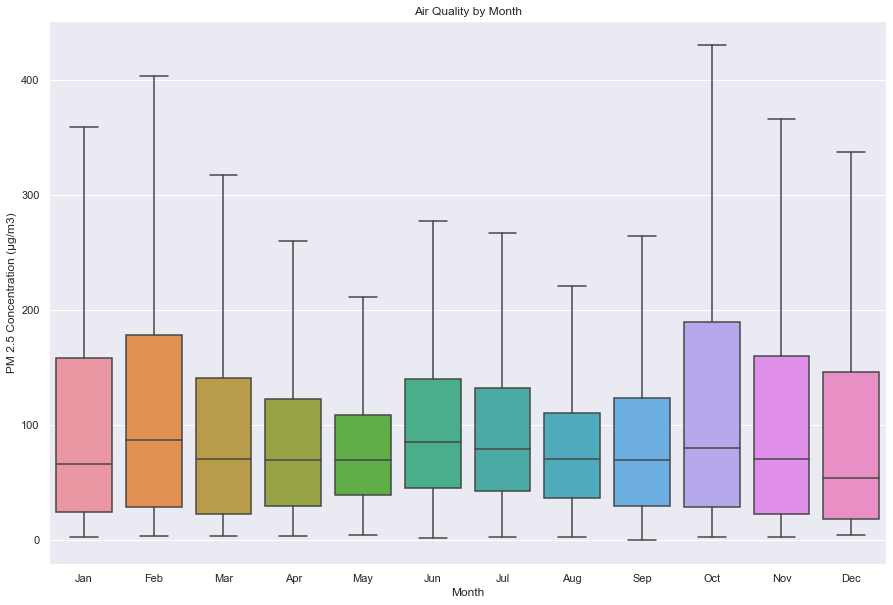

In [115]:
# Distribution of pollution over a year
import calendar
plt.figure(figsize=(15,10))
sns.boxplot(x="month", y="pm2.5", data=df, showfliers=False)
plt.xlabel('Month')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality by Month')
plt.xticks(range(0,12), calendar.month_abbr[1:13])
plt.show()

**Observation**:
Above plot defines a trend of air-pollution over the months in a year. Atmostspheric particle matter 2.5 concentration<br>
is more during colder months in Beijing, starting from October upto February when temperation and dew point is low. We <br>
see more outliers here as compared to warmer months from MArch to September when temp is high and there is rain.

In [116]:
df_numeric = df2.loc[:,['wind_spd','dew_pt','temp','pressure', 'cum_snow','cum_rain']]
df_numeric

,wind_spd,dew_pt,temp,pressure,cum_snow,cum_rain
time,,,,,,
2010-01-02 00:00:00,1.79,-16,-4.0,1020.0,0,0
2010-01-02 01:00:00,2.68,-15,-4.0,1020.0,0,0
2010-01-02 02:00:00,3.57,-11,-5.0,1021.0,0,0
2010-01-02 03:00:00,5.36,-7,-5.0,1022.0,1,0
2010-01-02 04:00:00,6.25,-7,-5.0,1022.0,2,0
...,...,...,...,...,...,...
2014-12-31 19:00:00,231.97,-23,-2.0,1034.0,0,0
2014-12-31 20:00:00,237.78,-22,-3.0,1034.0,0,0
2014-12-31 21:00:00,242.70,-22,-3.0,1034.0,0,0


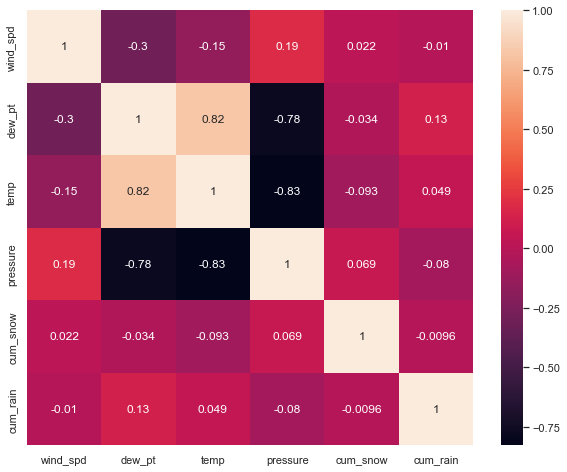

In [117]:
# Correlation between numerical columns
corr = df_numeric.corr()
plt.subplots(figsize=(10,8))
sns.heatmap(corr, annot=True)
plt.show()

**Observation**:
With time series data, sometimes there are autocorrelated residues. Here we see positive correlation between dew point and temperature.<br>
So modelling with linear regression will not be able to "capture all the trends" in the data.

## Modeling Time-Series using Regression
 Analytical modeling of the multivariate time series data is out of our scope. Yet we have tried to scale our data, split it into train and test data<br>
 and attempted to create models from some of our regression algorithms.


In [118]:
# Robust Scaling best addresses data with outliers
scaler = RobustScaler()
df3 = scaler.fit_transform(df_numeric)

In [119]:
# Covert array back to dataframe and summarize each input variable
df4 = pd.DataFrame(data=df3, index=df_numeric.index, columns=df_numeric.columns)
print(df4.describe())

           wind_spd        dew_pt          temp      pressure      cum_snow  \
count  43800.000000  43800.000000  43800.000000  43800.000000  43800.000000   
mean       0.920691     -0.006859     -0.073379      0.026312      0.052763   
std        2.486219      0.577173      0.580637      0.604201      0.760582   
min       -0.244533     -1.680000     -1.571429     -1.470588      0.000000   
25%       -0.177932     -0.480000     -0.571429     -0.470588      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.822068      0.520000      0.428571      0.529412      0.000000   
max       28.838469      1.040000      1.333333      1.764706     27.000000   

           cum_rain  
count  43800.000000  
mean       0.195023  
std        1.416247  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max       36.000000  


In [120]:
df4

,wind_spd,dew_pt,temp,pressure,cum_snow,cum_rain
time,,,,,,
2010-01-02 00:00:00,-0.177932,-0.72,-0.857143,0.235294,0.0,0.0
2010-01-02 01:00:00,-0.133698,-0.68,-0.857143,0.235294,0.0,0.0
2010-01-02 02:00:00,-0.089463,-0.52,-0.904762,0.294118,0.0,0.0
2010-01-02 03:00:00,-0.000497,-0.36,-0.904762,0.352941,1.0,0.0
2010-01-02 04:00:00,0.043738,-0.36,-0.904762,0.352941,2.0,0.0
...,...,...,...,...,...,...
2014-12-31 19:00:00,11.262425,-1.00,-0.761905,1.058824,0.0,0.0
2014-12-31 20:00:00,11.551193,-0.96,-0.809524,1.058824,0.0,0.0
2014-12-31 21:00:00,11.795726,-0.96,-0.809524,1.058824,0.0,0.0


After scaling and transforming, the summary of input variables show that the distributions have been adjusted. <br>
All the median values are now zero with standard deviation close to zero. There is significant changes in the max values.

In [121]:
df5 = df2.drop(['wind_spd','dew_pt','temp','pressure', 'cum_snow','cum_rain'], axis = 1)
final_df = pd.concat([df5,df4], axis = 1)
final_df

,pm2.5,NE,NW,SE,cv,wind_spd,dew_pt,temp,pressure,cum_snow,cum_rain
time,,,,,,,,,,,
2010-01-02 00:00:00,129.0,0,0,1,0,-0.177932,-0.72,-0.857143,0.235294,0.0,0.0
2010-01-02 01:00:00,148.0,0,0,1,0,-0.133698,-0.68,-0.857143,0.235294,0.0,0.0
2010-01-02 02:00:00,159.0,0,0,1,0,-0.089463,-0.52,-0.904762,0.294118,0.0,0.0
2010-01-02 03:00:00,181.0,0,0,1,0,-0.000497,-0.36,-0.904762,0.352941,1.0,0.0
2010-01-02 04:00:00,138.0,0,0,1,0,0.043738,-0.36,-0.904762,0.352941,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,0,1,0,0,11.262425,-1.00,-0.761905,1.058824,0.0,0.0
2014-12-31 20:00:00,10.0,0,1,0,0,11.551193,-0.96,-0.809524,1.058824,0.0,0.0
2014-12-31 21:00:00,10.0,0,1,0,0,11.795726,-0.96,-0.809524,1.058824,0.0,0.0


In [122]:
#Train-test Split 
features = final_df.drop("pm2.5",axis=1)
X = features
y = final_df['pm2.5']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 0)

In [123]:
# Get models using some of the regression algorithms
l_reg = LinearRegression()
tree_reg = DecisionTreeRegressor()
rnd_reg = RandomForestRegressor(n_estimators=30, random_state=0)
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, random_state=0)
lasso_reg = Lasso(alpha=0.1)
elastic_reg = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=0)
ridge_reg = Ridge(alpha=.5, solver="cholesky", random_state=0)
bag_reg = BaggingRegressor(
    DecisionTreeRegressor(random_state=0), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=0)

In [124]:
for reg in (l_reg,tree_reg,rnd_reg,sgd_reg,lasso_reg,elastic_reg,ridge_reg, bag_reg):
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    print(reg.__class__.__name__," r2_score: ",  r2_score(y_test, y_pred))
    print(reg.__class__.__name__,' MSE: ',  mean_squared_error(y_test, y_pred))
    print(reg.__class__.__name__," RMSE: " , np.sqrt(mean_squared_error(y_test, y_pred)))
    print('\n')

LinearRegression  r2_score:  0.24602288203012823
LinearRegression  MSE:  6464.377172592288
LinearRegression  RMSE:  80.40135056447924


DecisionTreeRegressor  r2_score:  -0.10736888080384199
DecisionTreeRegressor  MSE:  9494.253796430823
DecisionTreeRegressor  RMSE:  97.43846158694637


RandomForestRegressor  r2_score:  0.40010957537767355
RandomForestRegressor  MSE:  5143.283363063837
RandomForestRegressor  RMSE:  71.71668817690787


SGDRegressor  r2_score:  0.2440759046099953
SGDRegressor  MSE:  6481.069982082514
SGDRegressor  RMSE:  80.50509289531013


Lasso  r2_score:  0.24597771662849122
Lasso  MSE:  6464.764407409333
Lasso  RMSE:  80.40375866468764


ElasticNet  r2_score:  0.20453597104189192
ElasticNet  MSE:  6820.073697011799
ElasticNet  RMSE:  82.58373748512354


Ridge  r2_score:  0.24605675385982806
Ridge  MSE:  6464.086765526228
Ridge  RMSE:  80.39954456044032


BaggingRegressor  r2_score:  0.31745218470395486
BaggingRegressor  MSE:  5851.963423349938
BaggingRegressor  RMSE:

Random Forest Regressor was by far the best predictor and was still less than 50/50 in its prediction. Overall very poor performance from all of the models. 

As a conclusion, we have to say that to evaluate machine learning MVT (Multi-Variate TimeSeries) models, we need<br>
to prepare and develop our data, tune it and then split them into train and test data. Further we need to apply <br>
several algorithms and try out different models indepth to figure out the best forcasting model for our data, before<br>
we can aplly this model to test out on our test data.